In [1]:
import pandas as pd
import opendatasets as od
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
!pip3 install keras-tuner --upgrade
!pip3 install keras

Requirement already up-to-date: keras-tuner in /home/apprenant/PycharmProjects/ClimateProject---E3/env/lib/python3.8/site-packages (1.1.2)


In [2]:
od.download("https://www.kaggle.com/saurabhbagchi/ship-and-iceberg-images")

Skipping, found downloaded files in "./ship-and-iceberg-images" (use force=True to force download)


In [3]:
import os
for dirname, _, filenames in os.walk('/home/apprenant/PycharmProjects/ClimateProject---E3/ship-and-iceberg-images/input_data.npz'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 # Load the data

In [4]:
npz = np.load('/home/apprenant/PycharmProjects/ClimateProject---E3/Data analysis/ship-and-iceberg-images/input_data.npz')

x = npz['X_train']
y = npz['Y_train']
del npz

In [5]:
print('shape of picture: {}'.format(x.shape))
print('shape of picture: {}'.format(y.shape))

shape of picture: (4113, 75, 75, 3)
shape of picture: (4113,)


In [6]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.8, random_state=1, stratify=y_valtest)

In [7]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_val).shape)
print(np.array(y_test).shape)

(3290, 75, 75, 3)
(659, 75, 75, 3)
(164, 75, 75, 3)
(3290,)
(659,)
(164,)


In [8]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=5, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(75,75,3)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=5, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    keras.layers.Dropout(0.2),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=5, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.BatchNormalization(),    
    # output layer    
    keras.layers.Dense(10, activation='sigmoid')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
from tensorflow import keras
import keras_tuner

In [10]:
#creating randomsearch object
tuner = keras_tuner.RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 2,
                    overwrite=False)
# search best parameter
tuner.search(X_train,y_train,epochs=3,validation_data=(X_val,y_val))

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [11]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 21)        588       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 37)        7030      
_________________________________________________________________
dropout (Dropout)            (None, 71, 71, 37)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186517)            0         
_________________________________________________________________
dense (Dense)                (None, 85)                15854030  
_________________________________________________________________
batch_normalization (BatchNo (None, 85)                340       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8

In [12]:
history = model.fit(X_train,y_train,
          epochs=100,
          validation_split=0.1,initial_epoch=0)

Epoch 1/100
93/93 [==============================] - 18s 189ms/step - loss: 0.2112 - accuracy: 0.9149 - val_loss: 0.2028 - val_accuracy: 0.9271
Epoch 2/100
93/93 [==============================] - 17s 185ms/step - loss: 0.1008 - accuracy: 0.9605 - val_loss: 3.3654 - val_accuracy: 0.5319
Epoch 3/100
93/93 [==============================] - 17s 185ms/step - loss: 0.1031 - accuracy: 0.9629 - val_loss: 0.1973 - val_accuracy: 0.9362
Epoch 4/100
93/93 [==============================] - 17s 185ms/step - loss: 0.0613 - accuracy: 0.9764 - val_loss: 0.5800 - val_accuracy: 0.8693
Epoch 5/100
93/93 [==============================] - 17s 185ms/step - loss: 0.0658 - accuracy: 0.9764 - val_loss: 4.7736 - val_accuracy: 0.5228
Epoch 6/100
93/93 [==============================] - 17s 184ms/step - loss: 0.0480 - accuracy: 0.9824 - val_loss: 2.3465 - val_accuracy: 0.6353
Epoch 7/100
93/93 [==============================] - 17s 184ms/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 2.4989 - val_accuracy:

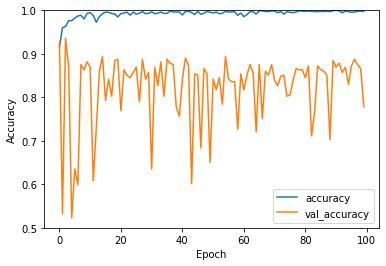

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [14]:
results = pd.DataFrame(history.history)
results.head()

,loss,accuracy,val_loss,val_accuracy
0,0.211246,0.914894,0.202755,0.927052
1,0.100840,0.960486,3.365376,0.531915
2,0.103122,0.962850,0.197268,0.936170
3,0.061267,0.976359,0.580013,0.869301
4,0.065758,0.976359,4.773645,0.522796


In [15]:
import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense

# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()

In [16]:
model = model

In [17]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("/home/apprenant/PycharmProjects/ClimateProject---E3/model/model_tuner.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/home/apprenant/PycharmProjects/ClimateProject---E3/model/model_tuner.h5")